# Fashion MNIST Data Science Challenge: Neural Networks and Deep Learning


This file contains the code as well as the explanations to our final model.

In [1]:
import datetime

FILE_PREFIX = ""
MODEL_PATH = FILE_PREFIX + "trained_models/model_{}".format(datetime.datetime.now().strftime("%d%m%Y_%H%M%S"))
WEIGHTS_PATH = MODEL_PATH + "/best_weights_checkpoint"

## Imports

In [2]:
#basic packages
import typing
import math  # needed by keras
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,GaussianNoise
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Set random state for constant results
np.random.RandomState(12345)  
tf.random.set_seed(12345)

In [3]:
# When true explanatory graphs and tensorboard are rendered -> impacts runtime
SHOW_EXPLANATORY_GRAPHS = True

In [4]:
# Save best weights of the model while training and load afterwards
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_PATH,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Data Preparation and Augmentation

### Random erasing
We are using a third-party github repository that implements random_erasing. You can find it [here](https://github.com/yu4u/cutout-random-erasing).

In [5]:
# Import random eraser from its python file
%run random_eraser/random_eraser

### Image augmentation
This function is used for data augmentation. It randomly changes the brightness or contrast of the image, deletes radom portions and possibly flips and rotates the input image. This expands the data set which improves the model's capability of generalization.

In [6]:
# About 50% Chance that any augmentation happens
ROTATION_CHANCE = 0.1
FLIP_CHANCE = 0.2 # actually 0.1 since tf.image.random_flip_left_right has 0.5 chance
CONSTRAST_CHANCE = 0.2 # actually 0.1 since tf.image.random_contrast has 0.5 chance
BRIGHTNESS_CHANCE = 0.2 # actually 0.1 since tf.image.random_brightness has 0.5 chance
ERASER_CHANCE = 0.25

In [7]:
# function that takes an image as input and creates a randomly augmented image as output
def get_dataset_augmentation_func(eraser_chance:float = ERASER_CHANCE,
                                  rotation_chance:float = ROTATION_CHANCE,
                                  flip_chance:float = FLIP_CHANCE,
                                  contrast_chance:float = CONSTRAST_CHANCE,
                                  brightness_chance:float = BRIGHTNESS_CHANCE) -> typing.Callable[[np.ndarray], np.ndarray]:
    """
    Creates a function that augments the input image or input image array with the
    given probabilities
    :param eraser_chance: Probability that a random portion of the image will be erased
    :type eraser_chance: float between 0 and 1
    :param rotation_chance: Probability that the image will be rotated by a multiple of 90 degrees (also random)
    :type rotation_chance: float between 0 and 1
    :param flip_chance: Probability that the image will be flipped left and right
    :type flip_chance: float between 0 and 1
    :param contrast_chance: Probability that the image contrast will be changed (currently not used)
    :type contrast_chance: float between 0 and 1
    :param brightness_chance: Probability that the image brightness will be changed (currently not used)
    :type brightness_chance: float between 0 and 1
    :return: A function that takes either an image (numpy array with shape (height, width, channels) or
                (height, width)) or a list with multiple images and returns the image(s) with augmentations
    :rtype: Callable[[np.ndarray], np.ndarray]
    """
    def dataset_augmentation(image: np.ndarray)->np.ndarray:
        """
        :param image: image or a list with multiple images that will be augmented
        :type image: numpy array with shape (height, width, channels) or (height, width) or (num_images, image.shape)
        :return: Augmented image(s)
        :rtype: numpy array with shape (height, width, channels) or (height, width) or (num_images, image.shape)
        """
        output_image = image
        
        ######## ERASER ########
        eraser = get_random_eraser(p=eraser_chance, s_l=0.04, s_h=0.2, v_l=-1, v_h=1, pixel_level=True)
        if output_image.ndim == 3 or output_image.ndim == 2:
            output_image = eraser(output_image)    
        else:
            for im_indx, image in enumerate(output_image):
                output_image[im_indx] = eraser(image)

        ######## ROTATE ########
        augmentation_chance = np.random.random_sample(size=None)
        rotation_amount = np.random.randint(0, high=4)
        if (augmentation_chance <= rotation_chance):
            # rotation_amount to degrees:
            # 0 = 0°
            # 1 = 90°
            # 2 = 180°
            # 3 = 270°
            # 4 (not possible) = 360° = 0°
            output_image = tf.image.rot90(output_image, k=rotation_amount)

        ######## FLIP ########
        augmentation_chance = np.random.random_sample(size=None)
        if (augmentation_chance <= flip_chance):
            output_image = tf.image.random_flip_left_right(output_image, seed=12345)

        # ######## CONTRAST ########
        # augmentation_chance = np.random.random_sample(size=None)
        # if (augmentation_chance <= contrast_chance):
        #     output_image = tf.image.random_contrast(output_image, 0.2, 0.5, seed=12345) 

        # ######## BRIGHTNESS ########
        # augmentation_chance = np.random.random_sample(size=None)
        # if (augmentation_chance <= brightness_chance):
        #     output_image = tf.image.random_brightness(output_image, 0.2, seed=12345) 

        return output_image
    
    return dataset_augmentation

### Data Preparation

In [8]:
#1. Get the file
data_train = pd.read_csv(FILE_PREFIX + 'train.csv')
data_validate = pd.read_csv(FILE_PREFIX + 'test.csv')
data_train = np.array(data_train, dtype = 'float32') # Damit Input Daten von Keras akzeptiert werden müssen wir sie in ein Array umwandeln 
data_validate = np.array(data_validate, dtype='float32') 

# Since we are using a Normalization layer and a Dataset, the preprocessing is only 
# reshaping the arrays and splitting the sets
x_train = data_train[:,1:]
y_train = data_train[:,0] #label data

data_submission = data_validate

#reshape the array containing the images (28px x 28px and 1 channel)
image_rows = 28
image_cols = 28
image_shape = (image_rows,image_cols,1)# 1 da schwarz weiß, bei Farbbildern 3 (r,g,b)

x_train = x_train.reshape(x_train.shape[0],*image_shape)
data_submission = data_submission.reshape(data_submission.shape[0],*image_shape)

#split train data in train and validation set
x_train2,x_validate2,y_train2,y_validate2 = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)

## Modeling

### Parameters

Mostly we decided our parameters by doing hyperparameter tuning via trial and error.

In [9]:
NUM_EPOCHS = 500
INIT_LR = 1e-3
BATCH_SIZE = 512
L2_PENALTY = 0.003
DATA_MEAN = np.mean(x_train2, axis=(0,1,2,3))
DATA_VARIANCE = np.var(x_train2, axis=(0,1,2,3))

#### Optimizer
There are multiple articles mentioning SGD as the best optimizer in the long term.
[This article](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/) compares the Adam and SGD optimizer and concludes that SGD with momentum and Nesterov results in a better validation accuracy.
Other articles suggest that even though Adam is faster in the beginning but SGD has better convergence in the long run.

Even though SGD might take more epochs to train, the network's accuracy ends up to be more stable.

In [10]:
our_optimizer = SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR/max(NUM_EPOCHS, 1))  # max to prevent divide by 0

#### Loss Function

The aim of this chapter is to evaluate the best loss function on an architecture. We do this by taking a subset of the training. Then we train our models with the different loss functions. Note that all loss functions are trained with the same data. After the training we evaluate the accuracy with: 1. training sample and 2. validation sample for our loss functions. To ensure that we are statistically correct we repeat this `n_survey` times. We aggregate by taking the mean of all  `n_survey` as well as the variance.

In [11]:
if SHOW_EXPLANATORY_GRAPHS:
    n_epoch = 4
    n_survey = 6
    n_models = 3
    cnt = 0
    # initialize accuracy and its variance
    acc = np.zeros((n_epoch,n_models))
    acc_sq = np.zeros((n_epoch,n_models))
    # initialize validation accuracy and its variance
    vacc = np.zeros((n_epoch,n_models))
    vacc_sq = np.zeros((n_epoch,n_models))

    for ii in np.random.randint(1,100000,n_survey):
        # split rain data in train and validation set, use different random states
        x_tr,x_val,y_tr,y_val = train_test_split(x_train2,y_train2,test_size = 0.2,random_state = ii)
        # update count
        print('__________ ',np.round(cnt/n_survey *100),'% __________')
        cnt += 1


        # iterate through different models
        for jj in range(n_models):
            if jj==0:
                ## sparse categorical crossentropy
                # simple baseline model (to beat)
                msimple = Sequential([
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(.3),
                    Dense(128, activation='relu'),
                    Dropout(.3),
                    Dense(10,activation='softmax')
                ])

                # compile model
                msimple.compile(optimizer='adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

                # train model
                wsimple = msimple.fit(x_tr,y_tr,epochs=n_epoch,verbose=0,
                                      batch_size=64,
                                      validation_data=(x_val,y_val))

                print('\n sparse categorical crossentropy: ',end='')


            elif jj==1:
                ## categorical crossentropy
                # simple baseline model (to beat)
                msimple = Sequential([
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(.3),
                    Dense(128, activation='relu'),
                    Dropout(.3),
                    Dense(10,activation='softmax')
                ])

                # compile model
                msimple.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

                # train model
                wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                                      batch_size=64,
                                      validation_data=(x_val,to_categorical(y_val)))

                print('\n categorical crossentropy: ', end='')


            elif jj==2:
                ## categorical hinge
                # simple baseline model (to beat)
                msimple = Sequential([
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(.3),
                    Dense(128, activation='relu'),
                    Dropout(.3),
                    Dense(10,activation='softmax')
                ])

                # compile model
                msimple.compile(optimizer='adam',
                                loss='categorical_hinge',
                                metrics=['accuracy'])

                # train model
                wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                                      batch_size=64,
                                      validation_data=(x_val,to_categorical(y_val)))

                print('\n categorical hinge: ',end='')

            # save model acc
            tmp1 = wsimple.history['accuracy']
            acc[:,jj] += np.copy(tmp1) /n_survey
            acc_sq[:,jj] += np.copy(tmp1)**2 /n_survey
            tmp2 = wsimple.history['val_accuracy']
            vacc[:,jj] += np.copy(tmp2) /n_survey
            vacc_sq[:,jj] += np.copy(tmp2)**2 /n_survey
            print('acc ',np.round(np.max(tmp1),4),', val acc: ',np.round(np.max(tmp2),4))
    

__________  0.0 % __________

 sparse categorical crossentropy: acc  0.8936 , val acc:  0.8906

 categorical crossentropy: acc  0.888 , val acc:  0.8873

 categorical hinge: acc  0.107 , val acc:  0.0934
__________  17.0 % __________

 sparse categorical crossentropy: acc  0.8911 , val acc:  0.8843

 categorical crossentropy: acc  0.8901 , val acc:  0.8863

 categorical hinge: acc  0.1484 , val acc:  0.1031
__________  33.0 % __________

 sparse categorical crossentropy: acc  0.8898 , val acc:  0.8859

 categorical crossentropy: acc  0.8914 , val acc:  0.8883

 categorical hinge: acc  0.1131 , val acc:  0.097
__________  50.0 % __________

 sparse categorical crossentropy: acc  0.8894 , val acc:  0.8935

 categorical crossentropy: acc  0.892 , val acc:  0.8967

 categorical hinge: acc  0.8027 , val acc:  0.8197
__________  67.0 % __________

 sparse categorical crossentropy: acc  0.8919 , val acc:  0.8954

 categorical crossentropy: acc  0.8849 , val acc:  0.8921

 categorical hinge: a

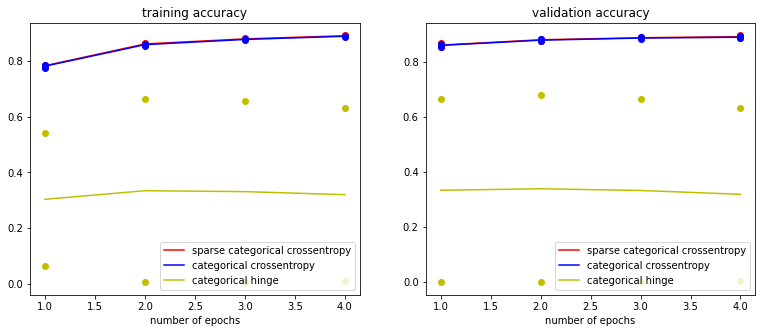

In [12]:
if SHOW_EXPLANATORY_GRAPHS:
    acc_std_err = (acc_sq - acc**2)**.5
    vacc_std_err = (vacc_sq - vacc**2)**.5
    models=['sparse categorical crossentropy','categorical crossentropy',
           'categorical hinge']
    mcolor = ['r','b','y']

    fig = plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    plt.title('training accuracy')
    for jj in range(n_models):
        plt.plot(np.arange(1,5),acc[:,jj],mcolor[jj]+'-', label=models[jj]);
        plt.plot(np.arange(1,5),acc[:,jj]+acc_std_err[:,jj],mcolor[jj]+'o');
        plt.plot(np.arange(1,5),acc[:,jj]-acc_std_err[:,jj],mcolor[jj]+'o');
        plt.legend(loc='lower right');
        plt.xlabel('number of epochs');

    plt.subplot(1,2,2)
    plt.title('validation accuracy')
    for jj in range(n_models):
        plt.plot(np.arange(1,5),vacc[:,jj],mcolor[jj]+'-', label=models[jj]);
        plt.plot(np.arange(1,5),vacc[:,jj]+vacc_std_err[:,jj],mcolor[jj]+'o');
        plt.plot(np.arange(1,5),vacc[:,jj]-vacc_std_err[:,jj],mcolor[jj]+'o');
        plt.legend(loc='lower right');
        plt.xlabel('number of epochs');

Solid lines in the plots indicate the mean over `n_survey` (=6) rounds. The dots are the standard errors. We conclude, that the `categorical_entropy` and `sparse_categorical_crossentropy` are the loss functions we want to consider further. As it turned out, the loss function below it the best for our advanced model. 

In [13]:
our_loss_function = 'sparse_categorical_crossentropy'

#### Activation Functions
For the hidden layers we are using ReLU since it is less prone to the vanishing gradient problem. Both ReLU and softmax are standard activation functions for image classification (blog post [here](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)).

In [14]:
model = Sequential([
        # Normalize values from [0,255) to [-1, 1)
        Normalization(input_shape=x_train.shape[1:], mean=DATA_MEAN, variance=DATA_VARIANCE),
    
        #3 convolutional layers followed by a max pooling layer
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        #next 3 convolutional layers followed by max pooling layer
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        GaussianNoise(0.1),
        Dropout(0.25),
    
        #3 dense layers followed by output layer
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        Dropout(0.25),

        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

In [15]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)      

In [16]:
## Kompilieren des Modells
model.compile(optimizer = our_optimizer,
                  loss= our_loss_function,
                  metrics = ['accuracy'])

## Training

In [17]:
training_dataset = ImageDataGenerator(horizontal_flip=True, 
                                      zoom_range=0.1, 
                                      preprocessing_function=get_dataset_augmentation_func(flip_chance=0.0))

In [18]:
history = model.fit(
    training_dataset.flow(x_train2, y_train2, batch_size=BATCH_SIZE),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(x_validate2, y_validate2),
    callbacks=[model_checkpoint_callback]
    )

Epoch 1/500
94/94 [==============================] - 75s 705ms/step - loss: 6.0415 - accuracy: 0.1823 - val_loss: 5.9054 - val_accuracy: 0.1383
Epoch 2/500
94/94 [==============================] - 60s 634ms/step - loss: 4.9908 - accuracy: 0.5230 - val_loss: 5.7720 - val_accuracy: 0.1075
Epoch 3/500
94/94 [==============================] - 60s 641ms/step - loss: 4.6701 - accuracy: 0.6223 - val_loss: 5.3271 - val_accuracy: 0.3594
Epoch 4/500
69/94 [=====================>........] - ETA: 15s - loss: 4.5084 - accuracy: 0.6583

KeyboardInterrupt: 

In [ ]:
# Load model checkpoint
model.load_weights(WEIGHTS_PATH)
# Saving the model 
model.save(MODEL_PATH)

## Prediction

We use a custom algorithm for image prediction.
### Grid Search
In training we used data augmentation in order to generalize. If we learn also augmented data, we also learn augmented structures. What if we augment the validation data, i.e. predict for many different augmented versions of the same image the class probabilities and aggregate afterwards?
We kind of steal the idea from the bagging algorithm. With bagging you train many models with different bootstrap samples. Then we predict test data with every model and then aggregate the class probabilities with e.g. the mean.
In our case, we just train one model, because training a neural net is very costly. But since we trained with augmentation we want to stabilize the prediction with the mean.

### Impact
In this implementation we use the same function as for training the model. Thus, our approach is a stochastic augmentation approach. We introduce a new hyperparamter `real_img_weight`. This scales the prediction of the real image, usually with a higher weight than the augmentation grid. The impact at this point is varying with dispersion due to the stochastic implementation. This, however, can be tuned. Due to time restriction, we did not really tune this and due to dispersion we take the prediction of the real images as our final submission. With a little paper search we did not find any paper that introduced augmenting the validation data and aggregation. But we did not really extended this search!

In [ ]:
def predict(input_data: np.ndarray, grid_size:int = 6) -> np.ndarray:
    """
    Custom predict function using grid search
    :param input_data: Input images that will be predicted
    :type input_data: An array containing images of shape(28, 28, 1)
    :param grid_size: Number of tests performed
    :type grid_size: int > 2
    :return: The predicted classes
    :rtype: numpy array with shape (len(input_data), 10)
    """
    assert(input_data[0].shape == (28,28,1))
    assert(grid_size > 1)
    # Init weight of real image
    real_img_weight = 0.3

    augmentedResults = []
    # Predict unaugmented image
    augmentedResults.append(model.predict(input_data) * real_img_weight)  
    # predict image with augmented data (grid_size - 1 times)
    augmentedResults.extend([model.predict(get_dataset_augmentation_func(rotaion_chance=ROTATION_CHANCE*2,
                                                                         flip_chance = FLIP_CHANCE*3,
                                                                         contrast_chance = CONSTRAST_CHANCE*3,
                                                                         brightness_chance = BRIGHTNESS_CHANCE*3
                                                                         )(np.copy(input_data)))*(1-w)/(grid_size-1) for _ in range(grid_size - 1)])
    
    return np.sum(augmentedResults, axis=0)

# Returns the accuracy
def evaluate(input_data: np.ndarray, input_labels: np.ndarray, grid_size:int = 6) -> float:
    """
    Evaluates the given input images
    :param input_data: Input images that will be predicted
    :type input_data: An array containing images of shape(28, 28, 1)
    :param input_labels: Labels matching the images
    :type input_labels: A float array of the shape (len(input_images))
    :param grid_size: Number of tests performed
    :type grid_size: int > 2
    :return: The accuracy of the model
    :rtype: float
    """
    assert(len(input_data) == len(input_labels))
    prediction = predict(input_data, grid_size)
    prediction = np.argmax(prediction, axis = 1)
    
    return np.count_nonzero(prediction == input_labels) / len(input_labels)

## Visualization

In [ ]:
score_non_grid = model.evaluate(x_validate2,y_validate2,verbose=0)
score_grid = evaluate(x_validate2,y_validate2)
print('Test Accuracy without grid: {:.4f}'.format(score_non_grid[1]))
print('Test Accuracy with grid: {:.4f}'.format(score_grid))

In [ ]:
# Test grid search prediction
n_survey = 10
grid_survey = np.empty((n_survey,))
for survey_ind in range(n_survey):
    grid_survey[survey_ind] = evaluate(x_validate2,y_validate2)

plt.hist(grid_survey) 

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Training Loss
    plt.figure(figsize=(20, 10))

    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Training Accuracy
    plt.figure(figsize=(20, 10))

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training - Accuracy Function')

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Confusion matrix with grid
    val_pred = np.argmax(predict(x_validate2), axis = 1)

    conf_matrix = pd.DataFrame(confusion_matrix(y_validate2, val_pred), index=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker","Bag", "Ankle boot"])
    plt.figure(figsize = (10,7))
    sns.heatmap(conf_matrix, annot=True)

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Confusion matrix without grid
    val_pred = np.argmax(model.predict(x_validate2), axis = 1)

    conf_matrix = pd.DataFrame(confusion_matrix(y_validate2, val_pred), index=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker","Bag", "Ankle boot"])
    plt.figure(figsize = (10,7))
    sns.heatmap(conf_matrix, annot=True)

## Submission

In [ ]:
# predict results
results = model.predict(data_submission)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
data_results = pd.DataFrame(results)
data_results.to_csv(FILE_PREFIX + 'fashion_mnist_pred_team1.csv', index=False)#Bitte statt X eure Gruppennummer einfügen! 

## Our Learnings
In the following part we reflect on our network and mention multiple points that could be improved for better classification performance.

### Parameters
Currently the hyperparameter tuning is done manually, but there are libraries (Like [this one](https://keras-team.github.io/keras-tuner/)) that implement systematic hyperparameter tuning. Since this process takes long and is very expensive (each setting needs to be tested after each other), and we (sadly) do not have the computational power to execute the process, we decided against using it. 


### Network Structure
In order to keep the computational complexity as low as possible we decided to use a more shallow structure.
Even though it performs very well research as well as the [official zalando github](https://github.com/zalandoresearch/fashion-mnist) suggest that a deeper network topography contributes to a more accurate classificaion. One of the inspirations for our network structure ([article here](https://medium.com/@mjbhobe/classifying-fashion-with-a-keras-cnn-achieving-94-accuracy-part-3-c7ca2919232b)) also mentions the benefits of a deeper network.

Additionally other structures like DenseNet (described in [this paper](https://arxiv.org/abs/1608.06993)) or ResNet variations can be used to boost accuracy. Tensorflow offers a wide range of pretrained models that can be easily used ([list here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)).

Also using cross validation (as described [here](https://towardsdatascience.com/3-methods-to-reduce-overfitting-of-machine-learning-models-4a7e2c1da9ef) and [here](https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/)) can help with minimizing overfitting, but it is computationally rather expensive since multiple models have to be trained.

### Data Preprocessing
While we used rudimentary data preprocessing functions, the model can benefit from a more extensive use of these methods. [This library](https://github.com/mdbloice/Augmentor) implements various image preprocessing functions that are well-suited for this purpose. Nethertheless the currently implemented preprocessor already increased the model's capability of generalization. A downside is that the accuracy fluctautes heavily in the beginning and training takes more epochs.

### Errors
The confusion matrix shows, that the network displays poor classification capabilities on some classes (like dresses and shirts) whereas it has no difficulty categorizing others (i.e. boots and bags). Sadly we were not able to eliminate these shortcomings. The main problem for this is the lack of training data, which cannot fully be overcome by data augmentation. However, as we have mentioned before, we believe that a higher accuracy is only obtainable for much deeper networks. Another problem we face is that our model still tends to overfit the training data. We have already tackled this issue by using batch normalisation layers, l2 penalty and dropout without complete success. Surprisingly, we found that increasing measures to overcome overfitting decreased the models overall performance which is why we chose not to tackle overfitting more.